In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer, LabelEncoder, MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ttest_rel, ttest_ind
from scipy import stats
from keras.layers import Input, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
# import cms_preprocess

2023-03-17 13:44:49.316264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:44:49.361108: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import keras
keras.__version__

'2.11.0'

In [6]:
keras.backend._get_available_gpus()

2023-03-16 15:40:33.682170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:33.696274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:33.696413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:33.696826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable the

['/device:GPU:0']

ue (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:34.005948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:34.006093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:34.006182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 15:40:34.006244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9871 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id

In [2]:
# def get_arthritis_patient_data(beneficiaries_df, inpatient_df, pde_df, start_year, end_year):
#   """
#   Process data to identify cases of patients with Rheumatoid Arthritis or Osteoarthritis.

#   Args:
#       beneficiaries_df (pandas.DataFrame): Dataframe containing beneficiaries data
#       inpatient_df (pandas.DataFrame): Dataframe containing inpatient data
#       start_year (int): Start year to filter data
#       end_year (int): End year to filter data

#   Returns:
#       pandas.DataFrame: Processed dataframe containing cases of patients with Rheumatoid Arthritis or Osteoarthritis.
#   """

#   # Merge beneficiaries and inpatient dataframes on DESYNPUF_ID
#   merged_df = pd.merge(beneficiaries_df, pde_df, on='DESYNPUF_ID', how='inner')
#   merged_df = pd.merge(merged_df, inpatient_df, on='DESYNPUF_ID', how='inner')

#   # Extract year from the Year column
#   # merged_df.dropna(subset=['CLM_FROM_DT'], inplace=True)
#   merged_df['CLM_FROM_DT'] = pd.to_numeric(merged_df['CLM_FROM_DT'], errors='coerce')

#   # Remove any missing values in CLM_FROM_DT
#   merged_df.dropna(subset=['CLM_FROM_DT'], inplace=True)
#   merged_df['CLM_FROM_DT'] = merged_df['CLM_FROM_DT'].astype(int)

#   # Extract year from the CLM_FROM_DT column
#   merged_df['Year'] = pd.to_datetime(merged_df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce').dt.year
#   merged_df.insert(4, "Year", merged_df.pop("Year"))  

#   # Filter data to only include years between start_year and end_year
#   merged_df = merged_df[(merged_df['Year'] >= start_year) & (merged_df['Year'] <= end_year)]
  
#   # Filter data to only include cases with Rheumatoid Arthritis/Osteoarthritis diagnosis
#   merged_df = merged_df[merged_df['SP_RA_OA'] == 1]
  
#   # Remove TJR surgeries in the first two years
#   merged_df = merged_df[~(merged_df['Year'].isin([start_year, start_year + 1]) & merged_df['CLM_DRG_CD'].isin(['469', '470']))]

#   # Filter data to only include patients fully enrolled in the selected years
#   full_enrollment_years = {year for year in range(start_year, end_year + 1)}
#   merged_df = merged_df[merged_df.groupby('DESYNPUF_ID')['Year'].transform(lambda x: set(x) >= full_enrollment_years)]
#   merged_df['Year'] = merged_df['Year'].astype(str)
  
#   # calculate age in years
#   merged_df['Age'] = (pd.to_datetime(merged_df['CLM_FROM_DT'],
#                                      format='%Y%m%d') - pd.to_datetime(merged_df['BENE_BIRTH_DT'],
#                                                                        format='%Y%m%d')).dt.days / 365
#   merged_df.insert(3, 'Age', merged_df.pop('Age'))

#   return merged_df

# data = get_arthritis_patient_data(beneficiaries_df=ben, inpatient_df=ip, pde_df=pde, start_year=2008, end_year=2010)


In [ ]:
# train_input, test_input, train_target, test_target, train_dv, test_dv = cms_preprocess.get_mhe(beneficiaries_df=cms_preprocess.ben,
#                                                  inpatient_df=cms_preprocess.ip, dx = cms_preprocess.dx, pcs= cms_preprocess.pcs, 
#                                                               start_year=2008, end_year=2010, rows = 10000, random_state = 42)

In [6]:
# np.save('data/cms/train_inp_balanced.npy', train_input.astype(bool))
# np.save('data/cms/train_dv_balanced.npy', train_dv)
# np.save('data/cms/test_inp_balanced.npy', test_input.astype(bool))
# np.save('data/cms/test_dv_balanced.npy', test_dv)
# np.save('data/cms/test_tar_balanced.npy', test_target.astype(bool))
# np.save('data/cms/train_tar_balanced.npy', train_target.astype(bool))

In [5]:
# np.save('data/cms/train_inp.npy', train_input.astype(bool))
# np.save('data/cms/train_dv.npy', train_dv)
# np.save('data/cms/test_inp.npy', test_input.astype(bool))
# np.save('data/cms/test_dv.npy', test_dv)
# np.save('data/cms/test_tar.npy', test_target.astype(bool))
# np.save('data/cms/train_tar.npy', train_target.astype(bool))

In [2]:
# train_input = np.load('data/cms/train_inp.npy')
# train_input = train_input.astype('float32')

# train_dv = np.load('data/cms/train_dv.npy')
# train_dv = train_dv

# train_target = np.load('data/cms/train_tar.npy')
# train_target = train_target.astype('float32')

In [2]:
train_input = np.load('data/cms/train_inp_balanced.npy')
train_input = train_input.astype('float32')

train_dv = np.load('data/cms/train_dv_balanced.npy')
train_dv = train_dv

train_target = np.load('data/cms/train_tar_balanced.npy')
train_target = train_target.astype('float32')

In [3]:
np.where(train_target==1)[0]

array([  33,  421,  466,  610,  912, 1024, 1221, 1395, 1496, 1868, 2231,
       2490, 2540, 2570, 3295, 3309, 3330, 3543, 3559, 3653, 3944, 4057,
       4138, 4234, 4396, 4504, 4550, 4592, 4767, 4861, 5233, 5563, 5585,
       5776, 5850, 5932, 5941, 6086, 6170, 6307, 6549, 6743, 6745, 6889,
       7144, 7247, 7362, 7560, 7832, 7870, 7964])

2023-03-17 13:25:56.875871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:25:56.889969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:25:56.890109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:25:56.890404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable the

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-17 13:26:01.418900: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 6400
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 366
        }
        dim {
          size: 516
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
 

Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-17 13:26:04.139577: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-17 13:26:05.484735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-17 13:26:06.266272: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-17 13:26:07.030694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-17 13:26:07.031041: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe8d002bd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-17 13:26:07.031053: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

26/26 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.9633

2023-03-17 13:26:09.033894: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1600
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 366
        }
        dim {
          size: 516
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
 

26/26 [==============================] - 8s 158ms/step - loss: 0.6086 - accuracy: 0.9633 - val_loss: 0.4967 - val_accuracy: 0.9937
Epoch 2/10
26/26 [==============================] - 2s 66ms/step - loss: 0.3759 - accuracy: 0.9936 - val_loss: 0.2922 - val_accuracy: 0.9937
Epoch 3/10
26/26 [==============================] - 2s 65ms/step - loss: 0.1959 - accuracy: 0.9937 - val_loss: 0.1601 - val_accuracy: 0.9937
Epoch 4/10
26/26 [==============================] - 2s 65ms/step - loss: 0.1031 - accuracy: 0.9937 - val_loss: 0.0966 - val_accuracy: 0.9937
Epoch 5/10
26/26 [==============================] - 2s 66ms/step - loss: 0.0611 - accuracy: 0.9939 - val_loss: 0.0657 - val_accuracy: 0.9937
Epoch 6/10
26/26 [==============================] - 2s 67ms/step - loss: 0.0409 - accuracy: 0.9941 - val_loss: 0.0490 - val_accuracy: 0.9937
Epoch 7/10
26/26 [==============================] - 2s 66ms/step - loss: 0.0291 - accuracy: 0.9944 - val_loss: 0.0395 - val_accuracy: 0.9937
Epoch 8/10
26/26 [=====

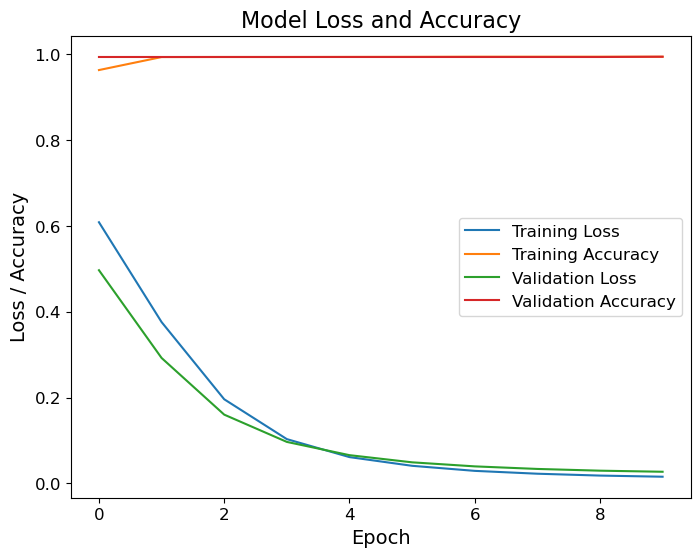

In [3]:
batch_size = 250
epochs=10

# Split the data into training and validation sets
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target,
                                                                     test_size=0.2, random_state=42, stratify=train_target)

# Create a tf.data.Dataset object from your data
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
train_dataset = train_dataset.shuffle(buffer_size=len(train_input))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
val_dataset = val_dataset.batch(batch_size)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Define the CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((366, 516, 1)), # reshape the input data into a 4D tensor
        tf.keras.layers.Conv2D(100, (366, 516), activation='relu'), # add a 2D convolutional layer with 100 filters
        tf.keras.layers.MaxPooling2D((1, 1)), # add a max pooling layer
        tf.keras.layers.Dropout(0.5), # add a dropout layer to prevent overfitting
        tf.keras.layers.Flatten(), # flatten the output from the convolutional layer
        tf.keras.layers.Dense(1, activation='sigmoid') # add a dense, fully connected layer with a sigmoid activation
    ])

    # Compile the model with both the loss and accuracy metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
    
    # Plot the loss and accuracy
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title('Model Loss and Accuracy', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss / Accuracy', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    plt.show()


In [11]:
# Save the model
model.save('models/cnn_10000b.h5')

In [2]:
# Load the model
model = tf.keras.models.load_model('models/cnn_10000b.h5')

2023-03-17 13:45:03.925667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:45:03.940978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:45:03.941115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 13:45:03.941422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable the

In [10]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     # Define the CNN model
#     model = tf.keras.Sequential([
#         tf.keras.layers.Reshape((366, 516, 1)), # reshape the input data into a 4D tensor
#         tf.keras.layers.Conv2D(100, (366, 516), activation='relu'), # add a 2D convolutional layer with 100 filters
#         tf.keras.layers.MaxPooling2D((1, 1)), # add a max pooling layer
#         tf.keras.layers.Dropout(0.5), # add a dropout layer to prevent overfitting
#         tf.keras.layers.Flatten(), # flatten the output from the convolutional layer
#         tf.keras.layers.Dense(1, activation='sigmoid') # add a dense, fully connected layer with a sigmoid activation
#     ])

#     # Compile the model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     # Define the number of chunks
#     num_chunks = 30

#     # Calculate the size of each chunk
#     chunk_size = train_input.shape[0] // num_chunks

#     # Train the model in chunks
#     for i in range(num_chunks):
#         start_index = i * chunk_size
#         end_index = start_index + chunk_size
#         if i == num_chunks - 1:
#             end_index = train_input.shape[0]

#         chunk_input = train_input[start_index:end_index]
#         chunk_target = train_target[start_index:end_index]

#         model.fit(chunk_input, chunk_target, epochs=10, batch_size=250)


In [15]:
import tensorflow as tf


graph1 = K.get_config()


graph2 = K.get_graph()

# with graph1.as_default():
#     model1.predict(X) (or training)

# with graph2.as_default():
#     model2.predict(X) (or training)

In [16]:
graph1

device_count {
  key: "CPU"
  value: 1
}
device_count {
  key: "GPU"
  value: 1
}
gpu_options {
  visible_device_list: "0"
  experimental {
  }
}
allow_soft_placement: true
experimental {
}

In [ ]:
# strategy = tf.distribute.MirroredStrategy()
# # with graph1.as_default():
# with strategy.scope():
#     # Define the model
#     data_input = tf.keras.layers.Input(shape=(366, 516))  # input shape for non-demographic variables data
#     feature_input = tf.keras.layers.Input(shape=(2,))  # input shape for demographic variables
#     x = tf.keras.layers.Reshape((366, 516, 1))(data_input)  # reshape the input to a 4D tensor
#     x = tf.keras.layers.Conv2D(100, (366, 516), activation='relu')(x)  # convolutional layer with 100 filters
#     x = tf.keras.layers.MaxPooling2D((1, 1))(x)  # max pooling layer
#     x = tf.keras.layers.Dropout(0.5)(x)  # dropout layer to prevent overfitting
#     x = tf.keras.layers.Flatten()(x)  # flatten the output from the convolutional layer
#     concatenated = tf.keras.layers.concatenate([x, feature_input])  # concatenate the demographic variables with the flattened output
#     output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)  # dense, fully connected layer with a sigmoid activation
#     model = tf.keras.Model(inputs=[data_input, feature_input], outputs=output)  # define the model with inputs and outputs

#     # Compile the model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     # Define the number of chunks
#     num_chunks = 30

#     # Calculate the size of each chunk
#     chunk_size = train_input.shape[0] // num_chunks

#     # Train the model in chunks
#     for i in range(num_chunks):
#         start_index = i * chunk_size
#         end_index = start_index + chunk_size
#         if i == num_chunks - 1:
#             end_index = train_input.shape[0]

#         chunk_data = train_input[start_index:end_index]
#         chunk_features = train_dv[start_index:end_index]
#         chunk_target = train_target[start_index:end_index]

#         model.fit([chunk_data, chunk_features], chunk_target, epochs=10, batch_size=250)

In [10]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

In [18]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    # config = tf.compat.v1.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = 1
    # config.gpu_options.visible_device_list = "0"
    # set_session(tf.Session(config=config))
    # sess.

In [25]:
reset_keras()

2023-03-16 16:24:55.873778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:24:55.875475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:24:55.876541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:24:55.878202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:24:55.878670: I tensorflow/compiler/xla/stream_executo

11783


In [21]:
num_clear()

In [12]:
# test_input = np.load('/localhome/ada104/orx/data/cms/test_inp.npy')
# test_input = test_input.astype('float32')

# test_dv = np.load('/localhome/ada104/orx/data/cms/test_dv.npy')

# test_target = np.load('/localhome/ada104/orx/data/cms/test_tar.npy')
# test_target = test_target.astype('float32')

In [3]:
test_input = np.load('data/cms/test_inp_balanced.npy')
test_input = test_input.astype('float32')

test_dv = np.load('data/cms/test_dv_balanced.npy')

test_target = np.load('data/cms/test_tar_balanced.npy')
test_target = test_target.astype('float32')

In [4]:
# Set batch size and number of chunks
batch_size = 8
num_chunks = 30

# Split test data and demographic variables into chunks
chunk_size = len(test_input) // num_chunks
test_chunks = [test_input[i:i+chunk_size] for i in range(0, len(test_input), chunk_size)]
feature_chunks = [test_dv[i:i+chunk_size] for i in range(0, len(test_dv), chunk_size)]

# Get predictions for each chunk of data
predictions = []
for i, chunk in enumerate(test_chunks):
    feature_chunk = feature_chunks[i]
    chunk_predictions = model.predict([chunk, feature_chunk], batch_size=batch_size)
    predictions.append(chunk_predictions)

# Concatenate predictions from all chunks
predictions = np.concatenate(predictions, axis=0)


ValueError: in user code:

    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/sharedenvs/orx/lib/python3.10/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 366, 516) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>]


In [6]:
np.where(test_target==1)[0]

array([ 231,  363,  366,  468,  676,  702,  790, 1294, 1534, 1547, 1565,
       1715, 1721])

In [7]:
# Get the prediction for some samples in the test set
sample = test_input[np.where(test_target==1)[0]]
dv_sample = test_dv[np.where(test_target==1)[0]]

prediction = model.predict([np.array(sample), dv_sample])

# Print the prediction
print('Prediction:', prediction)

1/1 [==============================] - 0s 492ms/step
Prediction: [[0.00684254]
 [0.46906644]
 [0.25149068]
 [0.00504696]
 [0.01461605]
 [0.32881823]
 [0.5192098 ]
 [0.41432968]
 [0.00542646]
 [0.00684254]
 [0.01269953]
 [0.25149068]
 [0.4672401 ]]


In [17]:
# # Get the prediction for some samples in the test set
# sample = test_input[np.where(test_target==1)[0]]
# prediction = model.predict(np.array(sample))

# # Print the prediction
# print('Prediction:', prediction)

In [18]:
# # Set batch size and number of chunks
# batch_size = 8
# num_chunks = 30

# # Split test data into chunks
# chunk_size = len(test_input) // num_chunks
# test_chunks = [test_input[i:i+chunk_size] for i in range(0, len(test_input), chunk_size)]

# # Get predictions for each chunk of data
# predictions = []
# for chunk in test_chunks:
#     chunk_predictions = model.predict(chunk, batch_size=batch_size)
#     predictions.append(chunk_predictions)

# # Concatenate predictions from all chunks
# predictions = np.concatenate(predictions, axis=0)


In [8]:
preds = np.copy(predictions)
preds = np.squeeze(preds)

# Find the F1 score for different threshold values
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(test_target, (preds > t).astype(int), average='weighted') for t in thresholds]

# Find the threshold value that maximizes the F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:" ,best_threshold)

preds[preds >= best_threshold] = 1
preds[preds < best_threshold] = 0

Best threshold: 0.13


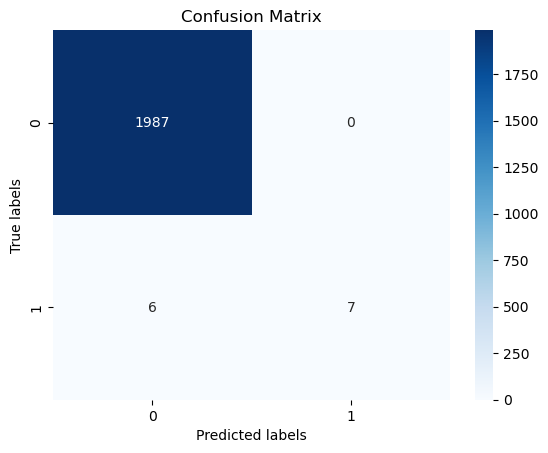

In [9]:
# Compute the confusion matrix
cm = confusion_matrix(test_target, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


AUC: 0.7692
Precision with recall set to 0.9: 1.0000


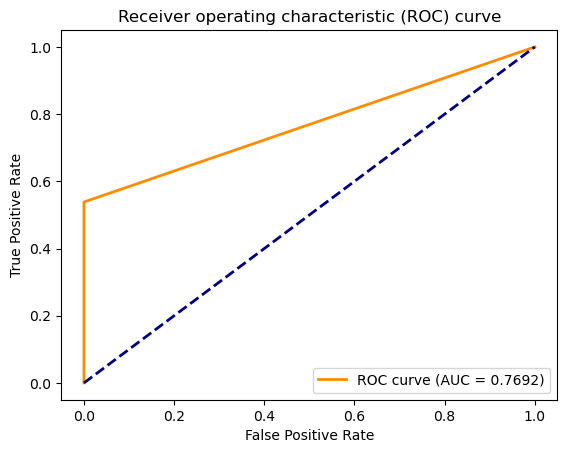

In [10]:
# Compute the AUC
auc_score = roc_auc_score(test_target, preds)
print("AUC: {:.4f}".format(auc_score))

# Compute the precision with recall set to 0.9
precision, recall, thresholds = precision_recall_curve(test_target, preds)
idx = (recall >= 0.9).argmin()
precision_at_recall_09 = precision[idx]
print("Precision with recall set to 0.9: {:.4f}".format(precision_at_recall_09))

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(test_target, preds)

# Compute the area under the curve (AUC)
roc_auc_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.show()


In [18]:
def num_clear():
    from numba import cuda
    cuda.select_device(0)
    cuda.close()